# Import Library and Load Data

Link dataset: https://www.kaggle.com/datasets/mdatikurrahman3111/vegetables-quality-dataset-2

In [ ]:
!pip install opencv-contrib-python

import numpy as np, matplotlib.pyplot as plt, seaborn as sns, cv2, cv2.ximgproc, os, math, pandas as pd
from pathlib import Path
from collections import Counter
from scipy.ndimage import label as scipy_label

# Machine Learning & Metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature Extractors
from skimage.feature import local_binary_pattern, hog

import warnings
warnings.filterwarnings('ignore')

# Konfigurasi Plotting
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries berhasil diimpor")

Libraries berhasil diimpor


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path diatur ke: /content/drive/MyDrive/PCVK/dataset_cm2/New Data
Membaca direktori...
  -> Loading Bad Quality Carrot: 691 images
  -> Loading Bad Quality Potato: 260 images
  -> Loading Bad Quality Tomato: 288 images
  -> Loading Good Quality Carrot: 347 images
  -> Loading Good Quality Potato: 217 images
  -> Loading Good Quality Tomato: 424 images

Total Gambar Dimuat: 2227

Jumlah data per kualitas:
- Rusak: 1239 gambar
- Utuh: 988 gambar


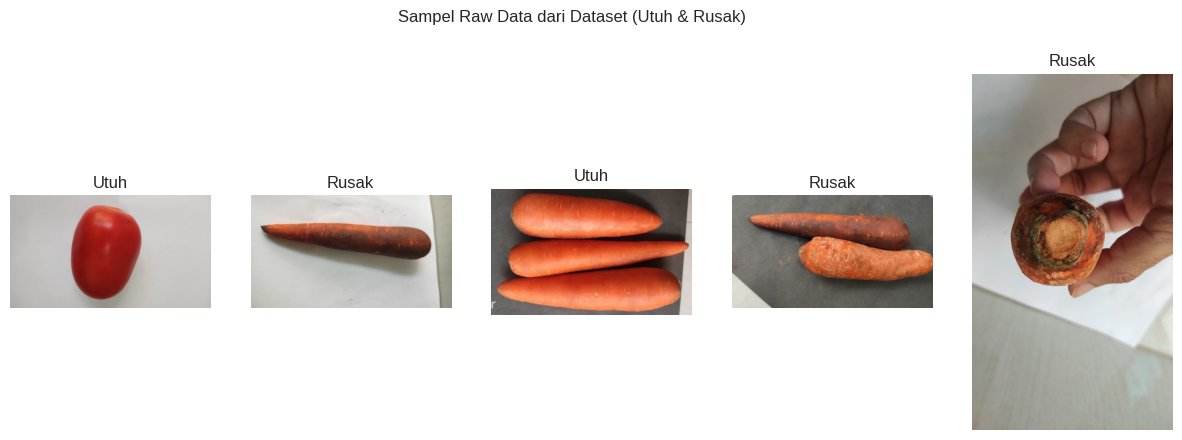

In [ ]:
# ==========================================
# STEP 1: LOAD DATA & VISUALISASI RAW DATA
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Format folder harus: "Bad Quality Potato", "Good Quality Carrot", dsb.
dataset_path = Path(r"/content/drive/MyDrive/PCVK/dataset_cm2/New Data")

print(f"Dataset Path diatur ke: {dataset_path}")

def parse_folder_info(folder_name):
    # Mengekstrak label utuh dan rusak
    name_lower = folder_name.lower()

    # Deteksi Kualitas
    quality = "Utuh" if "good" in name_lower else ("Rusak" if "bad" in name_lower else None)

    return quality

raw_images = [] # This will now store file paths
labels_quality = []

if dataset_path.exists():
    print("Membaca direktori...")
    for folder in sorted(dataset_path.iterdir()):
        if folder.is_dir():
            # Now parse_folder_info only returns 'qual'
            qual = parse_folder_info(folder.name)
            # We no longer need 'vtype' in this step for labels_type
            if qual:
                # Ambil semua ekstensi gambar
                files = list(folder.glob("*.jpg")) + list(folder.glob("*.png")) + list(folder.glob("*.jpeg"))
                print(f"  -> Loading {folder.name}: {len(files)} images")

                for f in files:
                    # Store file path instead of the image data to save RAM
                    raw_images.append(f)
                    labels_quality.append(qual)
else:
    print("Error: Path tidak ditemukan!")

print(f"\nTotal Gambar Dimuat: {len(raw_images)}")

# Menghitung jumlah 'Utuh' dan 'Rusak'
label_counts = Counter(labels_quality)
print("\nJumlah data per kualitas:")
for label, count in label_counts.items():
    print(f"- {label}: {count} gambar")

# ==================================================
#              VISUALISASI SAMPEL
# ==================================================
if len(raw_images) > 0:
    # Pisahkan indeks untuk 'Utuh' dan 'Rusak'
    utuh_indices = [i for i, label in enumerate(labels_quality) if label == 'Utuh']
    rusak_indices = [i for i, label in enumerate(labels_quality) if label == 'Rusak']

    selected_indices = []
    # Ambil 2 sampel 'Utuh'
    if len(utuh_indices) >= 2:
        selected_indices.extend(np.random.choice(utuh_indices, 2, replace=False))
    elif len(utuh_indices) > 0:
        selected_indices.extend(utuh_indices)

    # Ambil 3 sampel 'Rusak' atau sisanya jika 'Utuh' tidak cukup
    num_rusak_to_take = 5 - len(selected_indices)
    if len(rusak_indices) >= num_rusak_to_take:
        selected_indices.extend(np.random.choice(rusak_indices, num_rusak_to_take, replace=False))
    elif len(rusak_indices) > 0:
        selected_indices.extend(rusak_indices)

    # Shuffle the selected indices to mix 'Utuh' and 'Rusak'
    np.random.shuffle(selected_indices)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        if i >= 5: # Limit to 5 plots even if more were selected due to small categories
            break
        plt.subplot(1, 5, i+1)
        # Load image on demand for visualization
        img_to_show = cv2.imread(str(raw_images[idx]))
        if img_to_show is not None:
            img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
            plt.imshow(img_to_show)
        else:
            # Handle case where image could not be loaded
            plt.text(0.5, 0.5, "Image Error", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(labels_quality[idx]) # Menambahkan label kualitas pada judul
        plt.axis('off')
    plt.suptitle("Sampel Raw Data dari Dataset (Utuh & Rusak)")
    plt.show()


# Preprocessing

In [ ]:
# ===================================================
# STEP 2: PREPROCESSING (Resize + Guided Filter)
# ===================================================

def calculate_psnr(original, processed):
    mse = np.mean((original.astype("float") - processed.astype("float")) ** 2)
    if mse == 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))


def resize_image(img, size=128):
    return cv2.resize(img, (size, size))


def guided_filter_smoothing(img_rgb, radius, eps):
    img_float = img_rgb.astype(np.float32) / 255.0
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    channels = []
    for c in range(3):
        ch = img_float[:, :, c]
        ch_filt = cv2.ximgproc.guidedFilter(guide=gray, src=ch, radius=radius, eps=eps)
        channels.append(ch_filt)

    smoothed = np.stack(channels, axis=2)
    return np.clip(smoothed * 255.0, 0, 255).astype(np.uint8)


# ======================================================================
#                   PREPROCESSING (NO AUGMENTATION)
# ======================================================================

preprocessed_images = []
psnr_after = []

print("Memulai Preprocessing...")

for img_path in raw_images:

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[SKIP] Error loading: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    orig_r = resize_image(img, 128)

    # Guided filter
    den_r = guided_filter_smoothing(orig_r, radius=5, eps=1e-4)

    # Simpan 1x saja
    preprocessed_images.append(den_r)

    # PSNR
    psnr_after.append(calculate_psnr(orig_r, den_r))


print(f"Total preprocessed image = {len(preprocessed_images)}")

print("\n====== HASIL PSNR ======")
print(f"Rata-rata : {np.mean(psnr_after):.2f} dB")
print(f"Minimum   : {np.min(psnr_after):.2f} dB")
print(f"Maksimum  : {np.max(psnr_after):.2f} dB")
print("========================\n")

# ==========================================
# VISUALISASI PREPROCESSING
# ==========================================

idx = np.random.randint(0, len(preprocessed_images))

raw_img = cv2.imread(str(raw_images[idx]))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

prep_img = preprocessed_images[idx]
psnr_val = calculate_psnr(resize_image(raw_img, 128), prep_img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(raw_img)
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(prep_img)
plt.title(f"Preprocessed\nPSNR = {psnr_val:.2f} dB")
plt.axis("off")

plt.tight_layout()
plt.show()


Memulai Preprocessing...


# Segmentation and Augmentation

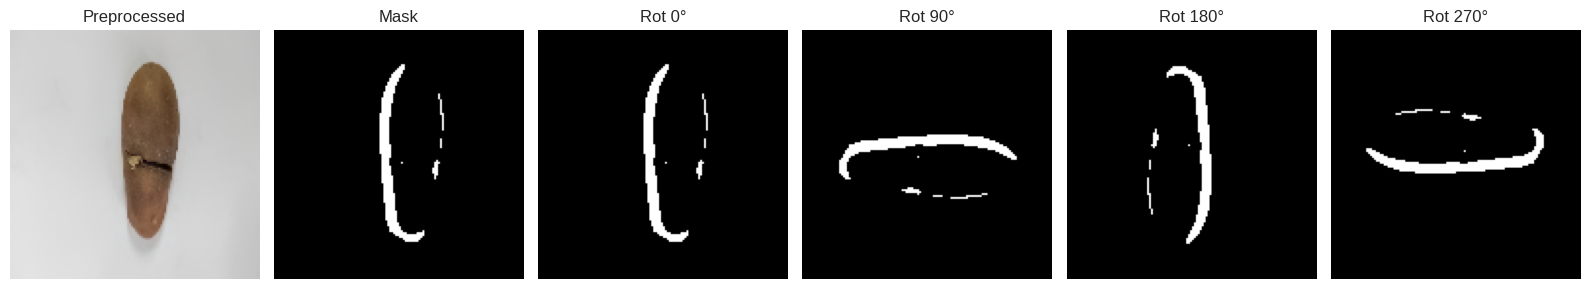

Jumlah citra asli              : 2227
Augmentasi per citra           : 4
Total citra setelah augmentasi : 8908


In [8]:
# ===================================================
# STEP 3: IMAGE SEGMENTATION + MASK AUGMENTASI
# ===================================================

def segmentation(preprocessed_img):
    # Kernel based on article
    Kh = np.array([
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2],
        [ 2, 1, 1, 1, -1, -1, -2]
    ], np.float32)

    Kv = np.array([
        [-2,-2,-2,-2,-2,-2,-2],
        [-1,-1,-1,-1,-1,-1,-1],
        [-1,-1,-1,-1,-1,-1,-1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 1, 1, 1, 1, 1, 1, 1],
        [ 2, 2, 2, 2, 2, 2, 2],
    ], np.float32)

    # 1. Convert to grayscale
    gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # 2. Convolution
    Gh = cv2.filter2D(gray, -1, Kh)
    Gv = cv2.filter2D(gray, -1, Kv)

    # 3. Select max gradient magnitude
    Gmag = np.maximum(np.abs(Gh), np.abs(Gv))
    Gmag_norm = cv2.normalize(Gmag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 4. Threshold
    _, mask = cv2.threshold(Gmag_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

# -------- MASK AUGMENTASI (0°, 90°, 180°, 270°) --------
def augment_mask(mask):
    mask = mask.astype(np.uint8)
    return [
        mask,  # 0°
        cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE),           # 90°
        cv2.rotate(mask, cv2.ROTATE_180),                    # 180°
        cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)     # 270°
    ]

# Buat aug_masks untuk semua citra
all_aug_masks = []
for img in preprocessed_images:
    mask = segmentation(img)          # mask hasil segmentasi citra
    masks = augment_mask(mask)        # list 4 rotasi
    all_aug_masks.append(masks)       # all_aug_masks[i][j] = mask citra ke-i rotasi ke-j

# ===================================================
# VISUALISASI SEGMENTASI + AUGMENTASI MASK (contoh 1 citra)
# ===================================================
idx = np.random.randint(0, len(preprocessed_images))
prep = preprocessed_images[idx]
mask = segmentation(prep)
aug_masks = augment_mask(mask)

plt.figure(figsize=(16, 6))
plt.subplot(1, 6, 1)
plt.imshow(prep)
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1, 6, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

titles = ["Rot 0°", "Rot 90°", "Rot 180°", "Rot 270°"]
for i, am in enumerate(aug_masks):
    plt.subplot(1, 6, i+3)
    plt.imshow(am, cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# ===================================================
# GENERATE X_data & y_qual_aug UNTUK SEMUA CITRA
# ===================================================
augment_angles = [0, 90, 180, 270]

# X_data = list of (index gambar, rotasi)
X_data = [(idx, angle) for idx in range(len(preprocessed_images)) for angle in augment_angles]

# y_qual_aug = label per citra diulang sesuai jumlah augmentasi
y_qual_aug = [label for label in labels_quality for _ in augment_angles]

print("Jumlah citra asli              :", len(preprocessed_images))
print("Augmentasi per citra           :", len(augment_angles))
print("Total citra setelah augmentasi :", len(X_data))

# Feature Extraction

In [9]:
# ==========================================
# EKSPERIMEN: MENCARI TAU OPTIMAL UNTUK CCV
# ==========================================

# Fungsi get_augmented_image
def get_augmented_image(img, angle):
    """Rotate image sesuai rotasi yang diberikan (0, 90, 180, 270)."""
    if angle == 0:
        return img
    elif angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

# Fungsi compute_ccv_hsv
def compute_ccv_hsv_experiment(image, mask, bins=(8,8,8), tau=50):
    """CCV asli di HSV hanya di area mask (coherent vs incoherent)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_bool = mask.astype(bool)
    h = hsv[:,:,0][mask_bool]
    s = hsv[:,:,1][mask_bool]
    v = hsv[:,:,2][mask_bool]

    # Quantize
    h_bins = np.linspace(0, 180, bins[0]+1)
    s_bins = np.linspace(0, 256, bins[1]+1)
    v_bins = np.linspace(0, 256, bins[2]+1)

    h_idx = np.digitize(h, h_bins) - 1
    s_idx = np.digitize(s, s_bins) - 1
    v_idx = np.digitize(v, v_bins) - 1

    total_bins = bins[0]*bins[1]*bins[2]
    coherent = np.zeros(total_bins)
    incoherent = np.zeros(total_bins)

    # label_map 2D untuk connected component
    label_map = np.zeros(mask_bool.shape, dtype=int)
    label_map[mask_bool] = np.arange(np.sum(mask_bool)) + 1

    for hi in range(bins[0]):
        for si in range(bins[1]):
            for vi in range(bins[2]):
                bin_mask_flat = (h_idx == hi) & (s_idx == si) & (v_idx == vi)
                if not np.any(bin_mask_flat):
                    continue
                bin_mask_2d = np.zeros(mask_bool.shape, dtype=bool)
                bin_mask_2d[mask_bool] = bin_mask_flat
                labeled, num_features = scipy_label(bin_mask_2d)  # Menggunakan scipy_label
                sizes = np.array([np.sum(labeled==i) for i in range(1, num_features+1)])
                coherent_pixels = np.sum(sizes[sizes>=tau])
                incoherent_pixels = np.sum(sizes[sizes<tau])
                bin_idx = hi*bins[1]*bins[2] + si*bins[2] + vi
                coherent[bin_idx] = coherent_pixels
                incoherent[bin_idx] = incoherent_pixels

    ccv_vector = np.concatenate([coherent, incoherent])
    ccv_vector = ccv_vector / (ccv_vector.sum() + 1e-6)
    return ccv_vector

# Fungsi untuk ekstrak fitur dengan tau yang bisa disesuaikan
def extract_features_with_tau(image, mask, tau_value):
    """Ekstrak fitur dengan tau yang bisa disesuaikan."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.uint8)
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_resized)

    # HOG
    fd_hog = hog(gray_masked, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=False)

    # LTP
    radius, n_points = 1, 8
    lbp = local_binary_pattern(gray_masked, n_points, radius, method='uniform')
    hist_ltp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0,n_points+2))
    hist_ltp = hist_ltp.astype(float)
    hist_ltp /= (hist_ltp.sum()+1e-6)

    # CLBP
    mean_val = np.mean(gray_masked)
    var_val = np.var(gray_masked)
    feat_clbp = np.append(hist_ltp, [mean_val, var_val])

    # CCV dengan tau yang disesuaikan (menggunakan fungsi lokal)
    ccv_feat = compute_ccv_hsv_experiment(image, mask_resized, bins=(8,8,8), tau=tau_value)

    return np.hstack([fd_hog, hist_ltp, feat_clbp, ccv_feat])


# ==========================================
# GRID SEARCH UNTUK TAU
# ==========================================

# Nilai-nilai tau yang akan dicoba
tau_candidates = [10, 20, 30, 40, 50]

# Sampel 30%
sample_size = int(len(X_data) * 0.30)
from sklearn.model_selection import StratifiedShuffleSplit
y_temp_full = np.array(y_qual_aug)
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
sample_indices, _ = next(sss.split(np.zeros(len(y_temp_full)), y_temp_full))

results = []

print("Mencari nilai tau optimal untuk CCV...")
print(f"Total data tersedia: {len(X_data)}")
print(f"Menggunakan {sample_size} sampel untuk eksperimen ({sample_size/len(X_data)*100:.1f}%)")

# Verifikasi distribusi kelas pada sampel
y_sample = np.array([y_qual_aug[i] for i in sample_indices])
unique, counts = np.unique(y_sample, return_counts=True)
print("\nDistribusi kelas pada sampel (Stratified):")
for label, count in zip(unique, counts):
    print(f"   {label}: {count} ({count/len(y_sample)*100:.1f}%)")

for tau_val in tau_candidates:
    print(f"Testing tau = {tau_val}...")

    # Ekstrak fitur dengan tau tertentu
    X_features_temp = []
    for idx in sample_indices:
        orig_idx, rot_angle = X_data[idx]
        img_proc = preprocessed_images[orig_idx]
        rot_idx = augment_angles.index(rot_angle)
        mask_aug = all_aug_masks[orig_idx][rot_idx]
        img_aug = get_augmented_image(img_proc, rot_angle)

        feats = extract_features_with_tau(img_aug, mask_aug, tau_val)
        X_features_temp.append(feats)

    X_features_temp = np.array(X_features_temp)
    y_temp = np.array([y_qual_aug[i] for i in sample_indices])

    # Encode labels
    le_temp = LabelEncoder()
    y_temp_enc = le_temp.fit_transform(y_temp)

    # Split data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_features_temp, y_temp_enc, test_size=0.3,
        random_state=42, stratify=y_temp_enc
    )

    # Scaling
    scaler_temp = StandardScaler()
    X_tr_s = scaler_temp.fit_transform(X_tr)
    X_te_s = scaler_temp.transform(X_te)

    # Train simple SVM
    svm_temp = SVC(kernel="rbf", C=1, gamma="auto", random_state=42)
    svm_temp.fit(X_tr_s, y_tr)

    # Evaluate
    train_acc_temp = accuracy_score(y_tr, svm_temp.predict(X_tr_s))
    test_acc_temp = accuracy_score(y_te, svm_temp.predict(X_te_s))

    results.append({
        'tau': tau_val,
        'train_acc': train_acc_temp,
        'test_acc': test_acc_temp,
        'gap': train_acc_temp - test_acc_temp
    })

    print(f"  Train Acc: {train_acc_temp:.4f} | Test Acc: {test_acc_temp:.4f} | Gap: {train_acc_temp - test_acc_temp:.4f}\n")

results_df = pd.DataFrame(results)


# ==========================================
# REKOMENDASI
# ==========================================

print("\nHasil eksperimen threshold CCV (tau)")
print(results_df.to_string(index=False))

# Cari tau dengan test accuracy tertinggi
best_by_test = results_df.loc[results_df['test_acc'].idxmax()]

# Cari tau dengan gap terkecil
best_by_gap = results_df.loc[results_df['gap'].idxmin()]

print("\nRekomendasi")
print(f"Tau dengan Test Accuracy tertinggi: {int(best_by_test['tau'])}")
print(f"   Test Acc: {best_by_test['test_acc']:.4f}")
print(f"\nTau dengan Gap terkecil (least overfitting): {int(best_by_gap['tau'])}")
print(f"   Gap: {best_by_gap['gap']:.4f}")

# Rekomendasi final
if best_by_test['gap'] <= 0.10:
    print(f"\nREKOMENDASI FINAL: Gunakan tau = {int(best_by_test['tau'])}")
    print(f"   (Test accuracy tertinggi dengan gap yang masih acceptable)")
else:
    print(f"\nREKOMENDASI FINAL: Gunakan tau = {int(best_by_gap['tau'])}")
    print(f"   (Gap terkecil untuk menghindari overfitting)")

Mencari nilai tau optimal untuk CCV...
Total data tersedia: 8908
Menggunakan 2672 sampel untuk eksperimen (30.0%)

Distribusi kelas pada sampel (Stratified):
   Rusak: 1487 (55.7%)
   Utuh: 1185 (44.3%)
Testing tau = 10...
  Train Acc: 0.9882 | Test Acc: 0.8092 | Gap: 0.1790

Testing tau = 20...
  Train Acc: 0.9872 | Test Acc: 0.8117 | Gap: 0.1754

Testing tau = 30...
  Train Acc: 0.9888 | Test Acc: 0.8055 | Gap: 0.1833

Testing tau = 40...
  Train Acc: 0.9840 | Test Acc: 0.7955 | Gap: 0.1884

Testing tau = 50...
  Train Acc: 0.9840 | Test Acc: 0.7980 | Gap: 0.1860


Hasil eksperimen threshold CCV (tau)
 tau  train_acc  test_acc      gap
  10   0.988235  0.809227 0.179008
  20   0.987166  0.811721 0.175445
  30   0.988770  0.805486 0.183284
  40   0.983957  0.795511 0.188446
  50   0.983957  0.798005 0.185952

Rekomendasi
Tau dengan Test Accuracy tertinggi: 20
   Test Acc: 0.8117

Tau dengan Gap terkecil (least overfitting): 20
   Gap: 0.1754

REKOMENDASI FINAL: Gunakan tau = 20
   (Ga

In [10]:
# ==========================================
# STEP 4: FEATURE EXTRACTION (HOG + LTP + CLBP + CCV)
# Menggunakan segmentasi + augmentasi untuk semua fitur
# ==========================================

def get_augmented_image(img, angle):
    """Rotate image sesuai rotasi yang diberikan (0, 90, 180, 270)."""
    if angle == 0:
        return img
    elif angle == 90:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

def compute_ccv_hsv(image, mask, bins=(8,8,8), tau=20):
    """CCV asli di HSV hanya di area mask (coherent vs incoherent)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_bool = mask.astype(bool)
    h = hsv[:,:,0][mask_bool]
    s = hsv[:,:,1][mask_bool]
    v = hsv[:,:,2][mask_bool]

    # Quantize
    h_bins = np.linspace(0, 180, bins[0]+1)
    s_bins = np.linspace(0, 256, bins[1]+1)
    v_bins = np.linspace(0, 256, bins[2]+1)

    h_idx = np.digitize(h, h_bins) - 1
    s_idx = np.digitize(s, s_bins) - 1
    v_idx = np.digitize(v, v_bins) - 1

    total_bins = bins[0]*bins[1]*bins[2]
    coherent = np.zeros(total_bins)
    incoherent = np.zeros(total_bins)

    # label_map 2D untuk connected component
    label_map = np.zeros(mask_bool.shape, dtype=int)
    label_map[mask_bool] = np.arange(np.sum(mask_bool)) + 1

    for hi in range(bins[0]):
        for si in range(bins[1]):
            for vi in range(bins[2]):
                bin_mask_flat = (h_idx == hi) & (s_idx == si) & (v_idx == vi)
                if not np.any(bin_mask_flat):
                    continue
                bin_mask_2d = np.zeros(mask_bool.shape, dtype=bool)
                bin_mask_2d[mask_bool] = bin_mask_flat
                labeled, num_features = scipy_label(bin_mask_2d)
                sizes = np.array([np.sum(labeled==i) for i in range(1, num_features+1)])
                coherent_pixels = np.sum(sizes[sizes>=tau])
                incoherent_pixels = np.sum(sizes[sizes<tau])
                bin_idx = hi*bins[1]*bins[2] + si*bins[2] + vi
                coherent[bin_idx] = coherent_pixels
                incoherent[bin_idx] = incoherent_pixels

    ccv_vector = np.concatenate([coherent, incoherent])
    ccv_vector = ccv_vector / (ccv_vector.sum() + 1e-6)
    return ccv_vector

def extract_features_with_mask(image, mask):
    """Ekstrak fitur HOG, LTP, CLBP, dan CCV dari citra dengan mask."""
    # Resize mask agar sesuai citra
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_resized = mask_resized.astype(np.uint8)

    # Masked grayscale untuk HOG, LTP, CLBP
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_resized)

    # 1. HOG
    fd_hog = hog(gray_masked, orientations=9, pixels_per_cell=(8,8),
                 cells_per_block=(2,2), visualize=False)

    # 2. LTP Approx (LBP Uniform)
    radius, n_points = 1, 8
    lbp = local_binary_pattern(gray_masked, n_points, radius, method='uniform')
    hist_ltp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0,n_points+2))
    hist_ltp = hist_ltp.astype(float)
    hist_ltp /= (hist_ltp.sum()+1e-6)

    # 3. CLBP Approx
    mean_val = np.mean(gray_masked)
    var_val = np.var(gray_masked)
    feat_clbp = np.append(hist_ltp, [mean_val, var_val])

    # 4. CCV HSV asli
    ccv_feat = compute_ccv_hsv(image, mask_resized, bins=(8,8,8), tau=50)

    # Gabungkan semua fitur
    return np.hstack([fd_hog, hist_ltp, feat_clbp, ccv_feat])

# ==========================================
# Ambil fitur untuk semua citra + augmentasi
# ==========================================
X_features = []

print("Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...")
X_features = []

for k, (orig_idx, rot_angle) in enumerate(X_data):
    img_proc = preprocessed_images[orig_idx]

    # Ambil mask augmentasi
    rot_idx = augment_angles.index(rot_angle)
    mask_aug = all_aug_masks[orig_idx][rot_idx]

    # Rotate citra sesuai rotasi
    img_aug = get_augmented_image(img_proc, rot_angle)

    # Ekstrak fitur
    feats = extract_features_with_mask(img_aug, mask_aug)
    X_features.append(feats)

    if (k+1) % 500 == 0:
        print(f"  -> Processed {k+1}/{len(X_data)}")

X_features = np.array(X_features)
print(f"Feature shape = {X_features.shape}")

Mengekstrak fitur (HOG, LTP, CLBP menggunakan mask, CCV dari RGB, semua augmentasi)...
  -> Processed 500/8908
  -> Processed 1000/8908
  -> Processed 1500/8908
  -> Processed 2000/8908
  -> Processed 2500/8908
  -> Processed 3000/8908
  -> Processed 3500/8908
  -> Processed 4000/8908
  -> Processed 4500/8908
  -> Processed 5000/8908
  -> Processed 5500/8908
  -> Processed 6000/8908
  -> Processed 6500/8908
  -> Processed 7000/8908
  -> Processed 7500/8908
  -> Processed 8000/8908
  -> Processed 8500/8908
Feature shape = (8908, 9146)


# Encoding, Split Data, Scaling

In [11]:
# ================================================
# STEP 5 — ENCODING, SPLIT DATA, SCALING
# ================================================

# Encode labels
le_qual = LabelEncoder()
y_qual_enc = le_qual.fit_transform(y_qual_aug)

# Prepare indices to map features back to images for visualization
indices = np.arange(len(X_features))

# # LANGKAH 1: Split 20% / 40% / 40%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.80,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)

# SPLIT 30:70
# LANGKAH 1: Split 30% / 35% / 35%
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X_features, y_qual_enc, indices, test_size=0.70,
    random_state=42, stratify=y_qual_enc)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.50,
    random_state=42, stratify=y_temp)


# SPLIT 40:60
# # LANGKAH 1: Split 40% / 30% / 30%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.60,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 50:50
# # LANGKAH 1: Split 50% / 25% / 25%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.50,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 70:30
# # LANGKAH 1: Split 70% / 15% / 15%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.30,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 80:20
# # LANGKAH 1: Split 80% / 10% / 10%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.20,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)


# SPLIT 90:10
# # LANGKAH 1: Split 90% / 5% / 5%
# X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
#     X_features, y_qual_enc, indices, test_size=0.10,
#     random_state=42, stratify=y_qual_enc)

# X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
#     X_temp, y_temp, idx_temp, test_size=0.50,
#     random_state=42, stratify=y_temp)

print("Data Split:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

# LANGKAH 2: Scaling (FIT hanya pada training set!)
print("\nApplying StandardScaler...")
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)  # FIT + TRANSFORM pada train
X_val_s   = scaler.transform(X_val)        # Hanya TRANSFORM pada val
X_test_s  = scaler.transform(X_test)       # Hanya TRANSFORM pada test

print("Scaling completed")

Data Split:
  Train: (2672, 9146)
  Val:   (3118, 9146)
  Test:  (3118, 9146)

Applying StandardScaler...
Scaling completed


# SVM Clasification

Training

In [12]:
# ==========================================
# STEP 6 — TRAINING SVM (UTUH vs RUSAK)
# ==========================================

svm = SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=42)

svm.fit(X_train_s, y_train)
print("SVM Training Done")

# ---- Report training accuracy immediately after fitting ----
y_train_pred = svm.predict(X_train_s)
train_acc = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_acc*100:.2f}%\n")
print(classification_report(y_train, y_train_pred, target_names=le_qual.classes_))

SVM Training Done
Training Accuracy: 100.00%

              precision    recall  f1-score   support

       Rusak       1.00      1.00      1.00      1487
        Utuh       1.00      1.00      1.00      1185

    accuracy                           1.00      2672
   macro avg       1.00      1.00      1.00      2672
weighted avg       1.00      1.00      1.00      2672



Validation

Validation Accuracy: 86.50%

              precision    recall  f1-score   support

       Rusak       0.86      0.90      0.88      1734
        Utuh       0.87      0.82      0.84      1384

    accuracy                           0.86      3118
   macro avg       0.87      0.86      0.86      3118
weighted avg       0.87      0.86      0.86      3118



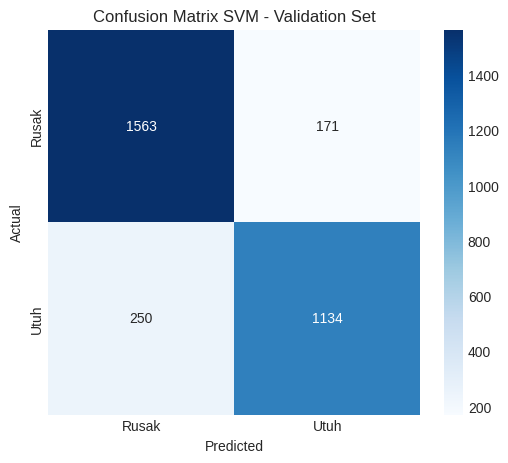

In [13]:
# ==========================================
# STEP 6 — VALIDASI SVM
# ==========================================
y_val_pred = svm.predict(X_val_s)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_acc*100:.2f}%\n")
print(classification_report(y_val, y_val_pred, target_names=le_qual.classes_))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le_qual.classes_,
            yticklabels=le_qual.classes_)
plt.title("Confusion Matrix SVM - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

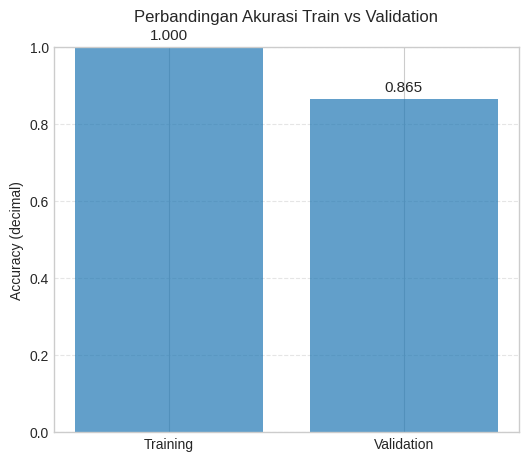


Evaluasi Training vs Validation
Training Accuracy:   1.0000
Validation Accuracy: 0.8650
Gap (Train - Val):   0.1350
⚠️ Overfitting: Train jauh lebih tinggi daripada Validation.


In [14]:
# ===================================================
# EVALUASI TRAIN vs VALIDATION
# ===================================================

# Hitung akurasi
acc = {
    "train": accuracy_score(y_train, y_train_pred),
    "val": accuracy_score(y_val, y_val_pred)
}
gap_tv = acc["train"] - acc["val"]

# Visualisasi (Bar Chart)
plt.figure(figsize=(6, 5))
plt.bar(["Training", "Validation"], [acc["train"], acc["val"]], alpha=0.7)

plt.title("Perbandingan Akurasi Train vs Validation\n")
plt.ylabel("Accuracy (decimal)")
plt.ylim(0, 1)

# Label di atas bar
for i, (label, value) in enumerate(acc.items()):
    plt.text(i, value + 0.02, f"{value:.3f}", ha="center", fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

print("\nEvaluasi Training vs Validation")
print(f"Training Accuracy:   {acc['train']:.4f}")
print(f"Validation Accuracy: {acc['val']:.4f}")
print(f"Gap (Train - Val):   {gap_tv:.4f}")

# Analisis kondisi model
if gap_tv > 0.10 and acc["val"] < acc["train"]:
    print("⚠️ Overfitting: Train jauh lebih tinggi daripada Validation.")
elif acc["train"] < 0.70 and acc["val"] < 0.70:
    print("⚠️ Underfitting: Keduanya rendah.")
else:
    print("✅ Good Fitting: Train dan Validation seimbang.")

Testing

Test Accuracy: 85.92%
              precision    recall  f1-score   support

       Rusak       0.85      0.90      0.88      1735
        Utuh       0.87      0.81      0.84      1383

    accuracy                           0.86      3118
   macro avg       0.86      0.85      0.86      3118
weighted avg       0.86      0.86      0.86      3118

Ringkasan Prediksi (Test Set):
Total Samples   : 3118
Total Benar   : 2679
Total Salah     : 439


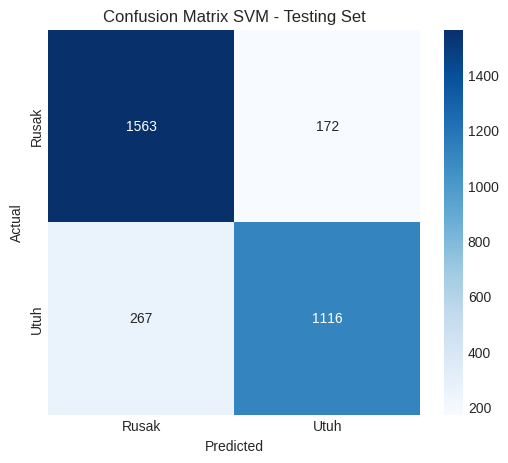

In [15]:
# ==========================================
# STEP 8 — TESTING SVM (FINAL)
# ==========================================
y_test_pred = svm.predict(X_test_s)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(classification_report(y_test, y_test_pred, target_names=le_qual.classes_))

# Ringkasan total prediksi benar vs salah
total_samples = len(y_test)
total_correct = int(np.sum(y_test_pred == y_test))
total_wrong = int(total_samples - total_correct)
print("Ringkasan Prediksi (Test Set):")
print(f"Total Samples   : {total_samples}")
print(f"Total Benar   : {total_correct}")
print(f"Total Salah     : {total_wrong}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le_qual.classes_,
            yticklabels=le_qual.classes_)
plt.title("Confusion Matrix SVM - Testing Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Ouput


Menampilkan 10 gambar test dengan prediksi...


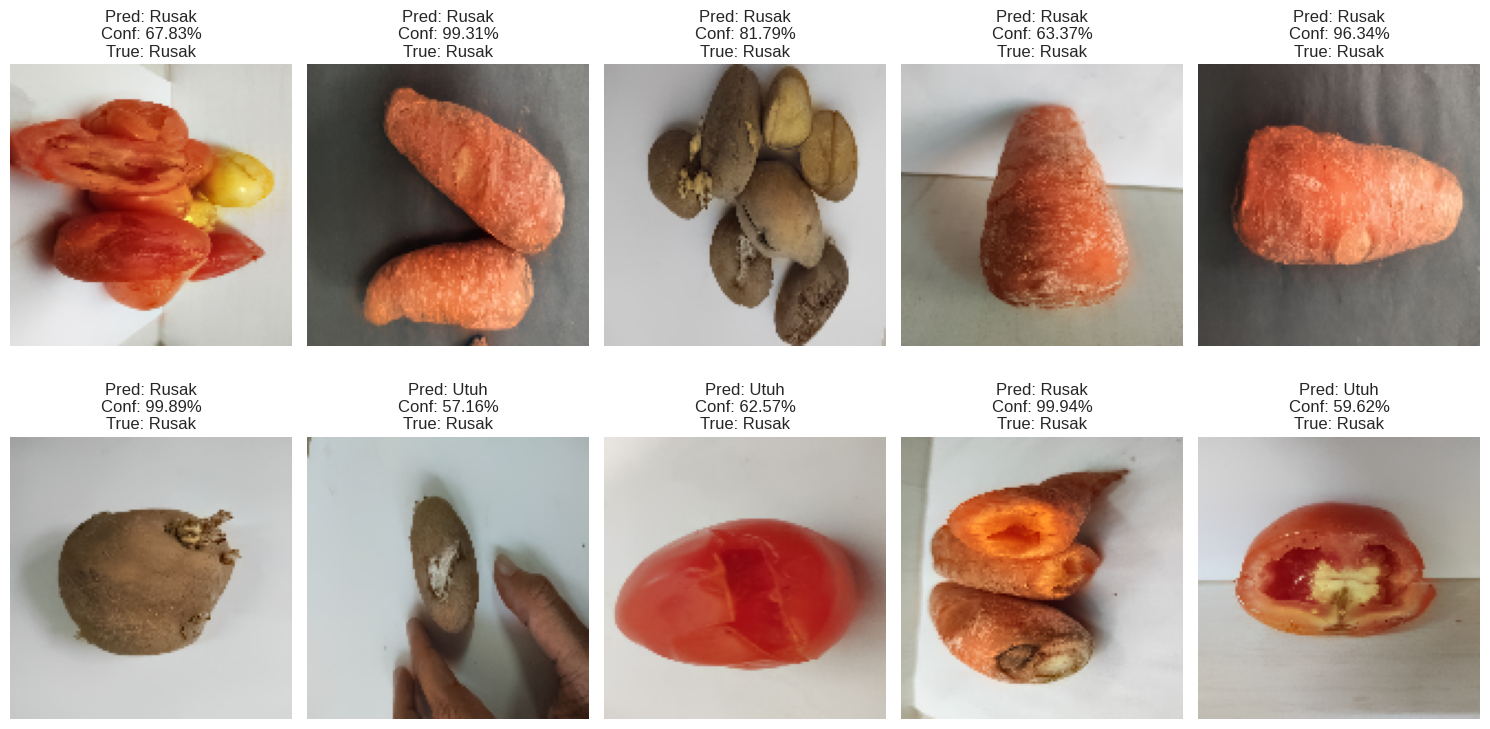

In [16]:
# ================================================
# OUTPUT KLASIFIKASI + CONFIDENCE (PROBABILITY)
# ================================================

# Ambil probabilitas
proba = svm.predict_proba(X_test_s)

# Prediksi kelas
pred_labels = svm.predict(X_test_s)

# Confidence = probabilitas kelas yang diprediksi
confidence = np.max(proba, axis=1)

# Mapping kembali ke label asli
label_map = {i: cls for i, cls in enumerate(le_qual.classes_)}


print("\nMenampilkan 10 gambar test dengan prediksi...")

indices_to_show = np.random.choice(len(X_test), 10, replace=False)

plt.figure(figsize=(15, 8))

for i, idx_in_test_set in enumerate(indices_to_show):
    plt.subplot(2, 5, i+1)
    # Retrieve the original preprocessed image using idx_test
    original_image_index = idx_test[idx_in_test_set]

    # X_data berisi tuple (index, angle), ambil hanya index untuk mendapatkan gambar
    img_idx, angle = X_data[original_image_index]
    img_show = preprocessed_images[img_idx]

    # Rotate image sesuai angle untuk visualisasi
    img_show = get_augmented_image(img_show, angle)

    plt.imshow(img_show)

    cls = label_map[pred_labels[idx_in_test_set]]
    conf = confidence[idx_in_test_set] * 100
    true = label_map[y_test[idx_in_test_set]]

    plt.title(f"Pred: {cls}\nConf: {conf:.2f}%\nTrue: {true}")
    plt.axis("off")

plt.tight_layout()
plt.show()